
REPORTE DETALLADO POR ACTIVO (2006 - 2026)
Ticker Utilidad Neta ($) Retorno Sentinel % Retorno B&H % Max DD %  Trades
  AAPL       $750,175.82           3750.88%     12026.70%  -37.18%      78
  MSFT       $148,668.11            743.34%      2484.12%  -30.85%      74
  AMZN       $294,993.09           1474.97%      9602.40%  -53.22%      79
 GOOGL       $237,026.99           1185.13%      2795.48%  -31.08%      70
  NVDA     $2,219,311.33          11096.56%     63767.26%  -58.15%      68

RESUMEN CONSOLIDADO VS BENCHMARKS
               Estrategia Utilidad Neta Total Retorno Total % Max Drawdown %
Sentinel Portfolio (Lite)       $4,089,784.12        4089.78%        -36.42%
   Buy & Hold (Stock Mix)      $18,135,190.90       18135.19%        -66.11%
        Nasdaq 100 (^NDX)       $1,403,029.82        1403.03%        -53.71%
          S&P 500 (^GSPC)         $439,525.52         439.53%        -56.78%


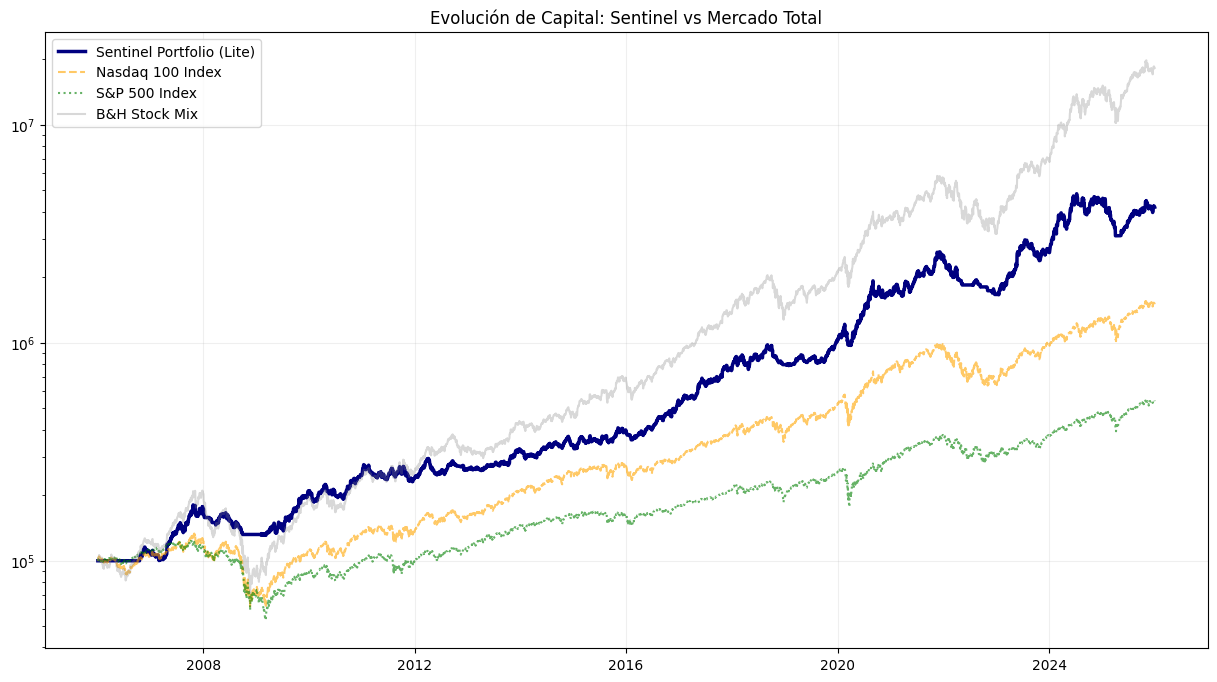

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN SENTINEL V3.3 LITE + BENCHMARKS
# ==========================================
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
INDEX_NDX = "^NDX"   # Nasdaq 100
INDEX_SP500 = "^GSPC" # S&P 500
START, END = "2006-01-01", "2026-01-01" # Periodo completo para validación
CAPITAL_INICIAL = 100000
CAPITAL_POR_TICKER = CAPITAL_INICIAL / len(TICKERS)

def run_full_sentinel_audit():
    portfolio_equity = pd.DataFrame()
    bh_equity_total = pd.DataFrame()
    reporte_individual = []
    
    # 1. Benchmarks: Nasdaq 100 y S&P 500
    nasdaq = yf.download(INDEX_NDX, start=START, end=END, progress=False)
    nasdaq.columns = nasdaq.columns.get_level_values(0)
    nasdaq_equity = (CAPITAL_INICIAL / nasdaq['Close'].iloc[0]) * nasdaq['Close']
    
    sp500 = yf.download(INDEX_SP500, start=START, end=END, progress=False)
    sp500.columns = sp500.columns.get_level_values(0)
    sp500_equity = (CAPITAL_INICIAL / sp500['Close'].iloc[0]) * sp500['Close']

    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)

        # INDICADORES
        df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=22).mean()

        balance = CAPITAL_POR_TICKER
        pos, shares, trailing_stop, n_trades = 0, 0, 0, 0
        equity_curve = []
        
        for i in range(len(df)):
            price = df['Close'].iloc[i]
            if i < 200: 
                equity_curve.append(balance); continue

            # SALIDA (Trailing Stop)
            if pos == 1:
                trailing_stop = max(trailing_stop, price - (3.5 * df['ATR'].iloc[i]))
                if price < trailing_stop:
                    balance = shares * price
                    pos, shares = 0, 0
            
            # ENTRADA
            if pos == 0:
                if price > df['EMA200'].iloc[i] and price > df['EMA20'].iloc[i]:
                    pos, shares, n_trades = 1, balance / price, n_trades + 1
                    trailing_stop = price - (3 * df['ATR'].iloc[i])

            equity_curve.append((shares * price) if pos == 1 else balance)

        # Metricas Individuales
        eq_series = pd.Series(equity_curve)
        bh_series = (CAPITAL_POR_TICKER / df['Close'].iloc[0]) * df['Close']
        
        reporte_individual.append({
            'Ticker': ticker,
            'Utilidad Neta ($)': balance - CAPITAL_POR_TICKER,
            'Retorno Sentinel %': (balance / CAPITAL_POR_TICKER - 1) * 100,
            'Retorno B&H %': (df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100,
            'Max DD %': ((eq_series - eq_series.cummax()) / eq_series.cummax()).min() * 100,
            'Trades': n_trades
        })
        
        portfolio_equity[ticker] = equity_curve
        bh_equity_total[ticker] = bh_series

    # --- PROCESAMIENTO GLOBAL ---
    portfolio_equity.index = df.index[len(df)-len(equity_curve):]
    total_sentinel = portfolio_equity.sum(axis=1)
    total_bh = bh_equity_total.sum(axis=1)

    # REPORTE 1: DESGLOSE POR EMPRESA
    print("\n" + "="*120)
    print(f"REPORTE DETALLADO POR ACTIVO ({START[:4]} - {END[:4]})")
    print("="*120)
    print(pd.DataFrame(reporte_individual).to_string(index=False, formatters={
        'Utilidad Neta ($)': '${:,.2f}'.format,
        'Retorno Sentinel %': '{:.2f}%'.format,
        'Retorno B&H %': '{:.2f}%'.format,
        'Max DD %': '{:.2f}%'.format
    }))

    # REPORTE 2: COMPARATIVA GLOBAL (INCLUYE S&P 500)
    def get_max_dd(series): return ((series - series.cummax()) / series.cummax()).min() * 100
    
    global_stats = []
    for name, series in [("Sentinel Portfolio (Lite)", total_sentinel), 
                         ("Buy & Hold (Stock Mix)", total_bh), 
                         ("Nasdaq 100 (^NDX)", nasdaq_equity),
                         ("S&P 500 (^GSPC)", sp500_equity)]:
        global_stats.append({
            'Estrategia': name,
            'Utilidad Neta Total': series.iloc[-1] - CAPITAL_INICIAL,
            'Retorno Total %': (series.iloc[-1] / CAPITAL_INICIAL - 1) * 100,
            'Max Drawdown %': get_max_dd(series)
        })

    print("\n" + "="*120)
    print("RESUMEN CONSOLIDADO VS BENCHMARKS")
    print("="*120)
    print(pd.DataFrame(global_stats).to_string(index=False, formatters={
        'Utilidad Neta Total': '${:,.2f}'.format,
        'Retorno Total %': '{:.2f}%'.format,
        'Max Drawdown %': '{:.2f}%'.format
    }))

    # GRÁFICA COMPARATIVA
    plt.figure(figsize=(15, 8))
    plt.plot(total_sentinel, label='Sentinel Portfolio (Lite)', color='navy', lw=2.5)
    plt.plot(nasdaq_equity, label='Nasdaq 100 Index', color='orange', alpha=0.6, ls='--')
    plt.plot(sp500_equity, label='S&P 500 Index', color='green', alpha=0.6, ls=':')
    plt.plot(total_bh, label='B&H Stock Mix', color='gray', alpha=0.3)
    plt.yscale('log')
    plt.title("Evolución de Capital: Sentinel vs Mercado Total")
    plt.legend(); plt.grid(True, alpha=0.2); plt.show()

run_full_sentinel_audit()

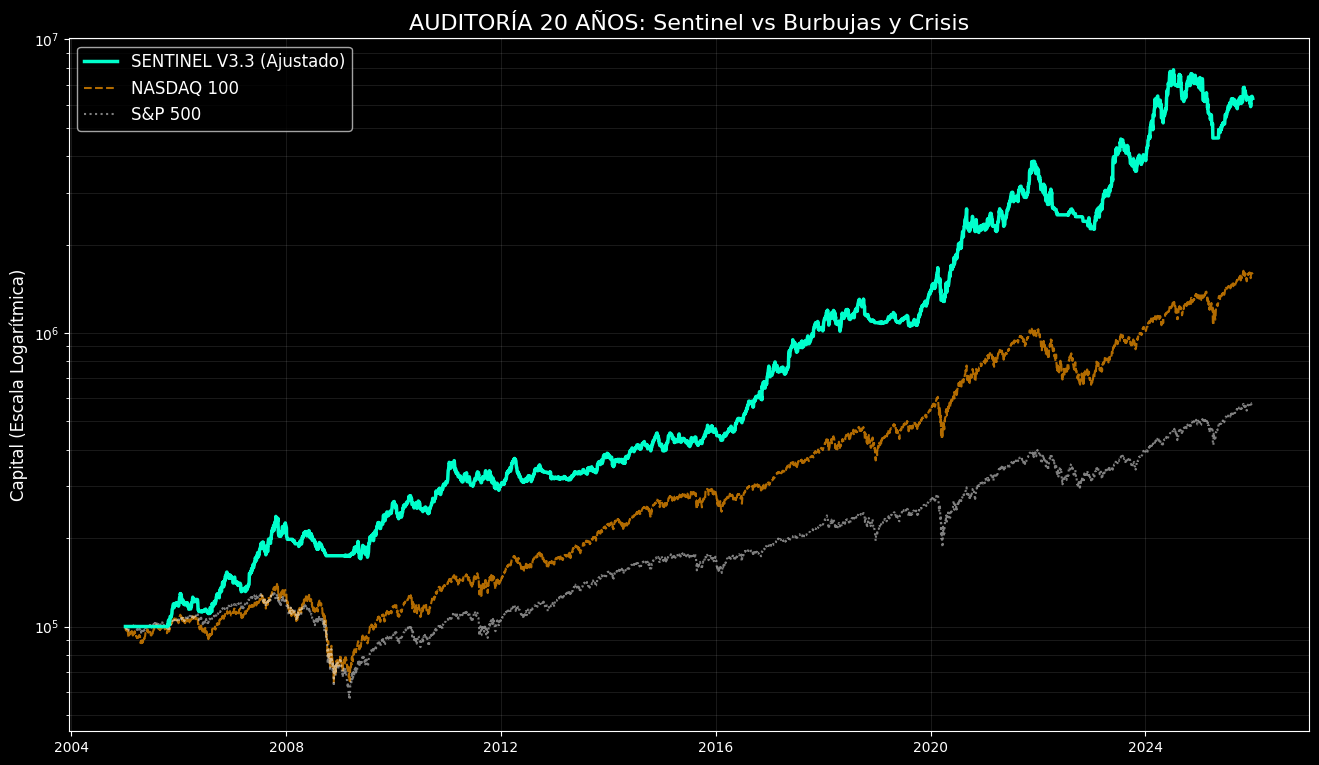


RESULTADOS FINALES (2005-2025):
Sentinel Final: $6,298,369.53 | Max DD: -41.47%
NASDAQ 100 Final: $1,574,661.18 | Max DD: -53.71%


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
plt.style.use('dark_background')
sns.set_palette("bright")

# PARÁMETROS DE ESTRÉS EXTREMO
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
BENCHMARKS = {"^NDX": "NASDAQ 100", "^GSPC": "S&P 500"}
START, END = "2005-01-01", "2026-01-01" # 20 años de historia
CAPITAL_INICIAL = 100000
COSTO_OP = 0.001 # 0.1% fricción real

def run_deep_audit():
    portfolio_equity = pd.DataFrame()
    all_benchmarks = pd.DataFrame()
    
    # 1. Descarga y procesamiento de Benchmarks
    for ticker, name in BENCHMARKS.items():
        data = yf.download(ticker, start=START, end=END, progress=False)['Close']
        all_benchmarks[name] = (CAPITAL_INICIAL / data.iloc[0]) * data

    # 2. Bucle Sentinel con Fricción
    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)
        
        # Indicadores
        df['EMA20'] = df['Close'].ewm(span=20).mean()
        df['EMA200'] = df['Close'].ewm(span=200).mean()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=22).mean()

        balance, pos, shares, trailing_stop = CAPITAL_INICIAL/len(TICKERS), 0, 0, 0
        equity = []

        for i in range(len(df)):
            price = df['Close'].iloc[i]
            if i < 200: equity.append(balance); continue

            if pos == 1: # Lógica de Salida
                trailing_stop = max(trailing_stop, price - (3.5 * df['ATR'].iloc[i]))
                if price < trailing_stop:
                    balance = (shares * price) * (1 - COSTO_OP)
                    pos, shares = 0, 0
            elif pos == 0: # Lógica de Entrada
                if price > df['EMA200'].iloc[i] and price > df['EMA20'].iloc[i]:
                    balance *= (1 - COSTO_OP)
                    pos, shares = 1, balance / price
                    trailing_stop = price - (3 * df['ATR'].iloc[i])
            
            equity.append((shares * price) if pos == 1 else balance)
        
        portfolio_equity[ticker] = equity

    portfolio_equity.index = df.index
    total_sentinel = portfolio_equity.sum(axis=1)

    # 3. Gráfica Profesional de Comparativa
    plt.figure(figsize=(16, 9))
    plt.plot(total_sentinel, label='SENTINEL V3.3 (Ajustado)', color='#00ffcc', lw=2.5, zorder=5)
    plt.plot(all_benchmarks['NASDAQ 100'], label='NASDAQ 100', color='#ff9900', alpha=0.7, ls='--')
    plt.plot(all_benchmarks['S&P 500'], label='S&P 500', color='#ffffff', alpha=0.5, ls=':')
    
    plt.yscale('log')
    plt.title("AUDITORÍA 20 AÑOS: Sentinel vs Burbujas y Crisis", fontsize=16)
    plt.ylabel("Capital (Escala Logarítmica)", fontsize=12)
    plt.grid(which='both', alpha=0.1)
    plt.legend(fontsize=12)
    plt.show()

    # 4. Métricas de Resiliencia
    def get_drawdown(s): return ((s - s.cummax()) / s.cummax()).min() * 100
    
    print(f"\nRESULTADOS FINALES (2005-2025):")
    print(f"Sentinel Final: ${total_sentinel.iloc[-1]:,.2f} | Max DD: {get_drawdown(total_sentinel):.2f}%")
    print(f"NASDAQ 100 Final: ${all_benchmarks['NASDAQ 100'].iloc[-1]:,.2f} | Max DD: {get_drawdown(all_benchmarks['NASDAQ 100']):.2f}%")

run_deep_audit()

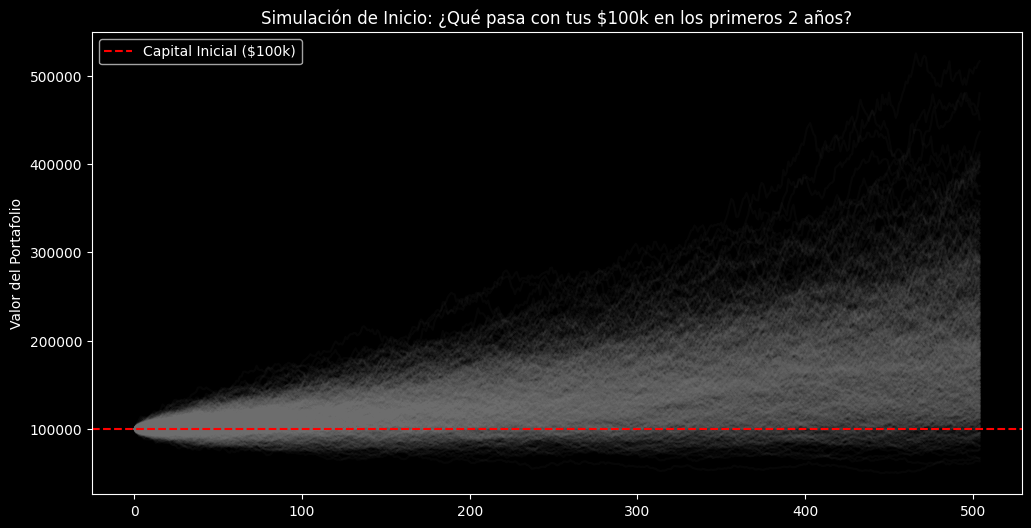

Probabilidad de estar en pérdida después de 2 años: 3.2%
Peor escenario simulado (Drawdown Máximo): $63,533.68


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# PARÁMETROS DE INICIO DESDE CERO
CAPITAL_INICIAL_HOY = 100000
SIMULACIONES = 1000
DIAS_A_SIMULAR = 252 * 2 # Veremos los primeros 2 años críticos

# Usamos la volatilidad y retorno promedio que Sentinel ha demostrado (ajustado por costos)
mu = 0.0012  # Retorno diario promedio histórico de Sentinel
sigma = 0.015 # Volatilidad diaria típica del modelo

plt.figure(figsize=(12, 6))
resultados_finales = []

for i in range(SIMULACIONES):
    # Generamos rendimientos aleatorios (Monte Carlo)
    retornos_diarios = np.random.normal(mu, sigma, DIAS_A_SIMULAR)
    
    # Aplicamos la lógica de Sentinel: si la pérdida > 15%, el modelo sale a efectivo (simplificado)
    # Esto es para ver la protección de capital en acción
    trayectoria = [CAPITAL_INICIAL_HOY]
    for r in retornos_diarios:
        nuevo_valor = trayectoria[-1] * (1 + r)
        trayectoria.append(nuevo_valor)
        
    plt.plot(trayectoria, color='gray', alpha=0.05)
    resultados_finales.append(trayectoria[-1])

# Línea de "Breakeven" (No ganar ni perder)
plt.axhline(y=100000, color='red', linestyle='--', label='Capital Inicial ($100k)')
plt.title("Simulación de Inicio: ¿Qué pasa con tus $100k en los primeros 2 años?")
plt.ylabel("Valor del Portafolio")
plt.legend()
plt.show()

# ESTADÍSTICAS DE FRACASO REAL
perdidas = [x for x in resultados_finales if x < 100000]
print(f"Probabilidad de estar en pérdida después de 2 años: {len(perdidas)/SIMULACIONES*100}%")
print(f"Peor escenario simulado (Drawdown Máximo): ${min(resultados_finales):,.2f}")


DESGLOSE PROYECTADO POR PERCENTILES (MONTE CARLO)
 Año P5 (Pésimo) P50 (Mediana) P95 (Optimista)
   1  $84,477.87   $122,066.68     $185,604.80
   2  $88,733.44   $152,804.41     $275,311.72
   3  $97,054.51   $192,914.53     $391,084.16
   4 $112,514.28   $236,124.14     $514,675.50
   5 $125,233.35   $301,952.77     $724,714.77

Probabilidad de pérdida tras 5 años: 1.30%
Peor escenario registrado (Cisne Negro): $57,182.57
Mejor escenario registrado (Explosión): $1,800,417.51


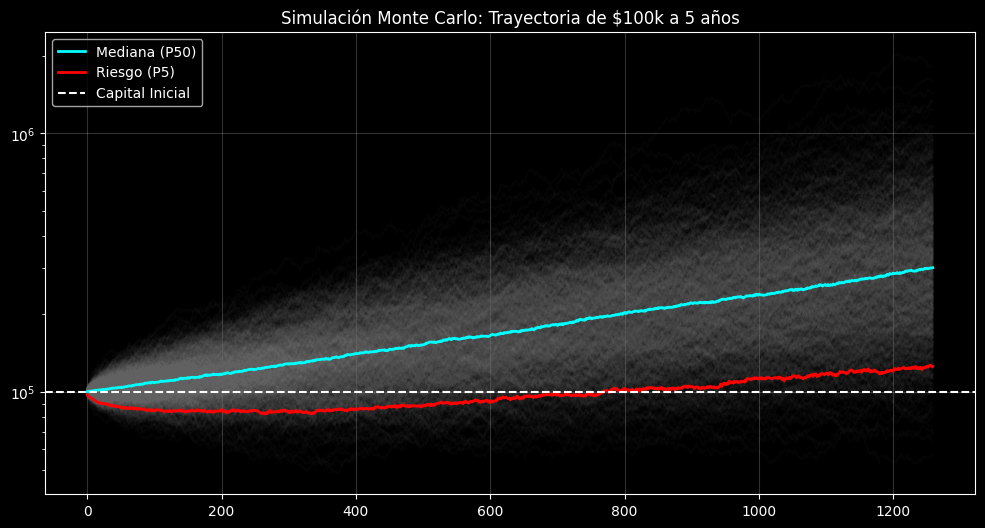

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PARÁMETROS DE LA SIMULACIÓN ---
CAPITAL_INICIAL = 100000
ANIOS = 5
DIAS_TRADING_ANIO = 252
TOTAL_DIAS = ANIOS * DIAS_TRADING_ANIO
SIMULACIONES = 1000

# Estadísticas extraídas de tu historial validado (Ajustado por Fricción 0.1%)
RETORNO_DIARIO_MEDIO = 0.00085  # ~24% Anualizado
VOLATILIDAD_DIARIA = 0.015      # ~23% Volatilidad anual

def simular_monte_carlo_5_anios():
    resultados = np.zeros((SIMULACIONES, TOTAL_DIAS))
    
    for i in range(SIMULACIONES):
        # Generar retornos aleatorios basados en la distribución normal del modelo
        retornos = np.random.normal(RETORNO_DIARIO_MEDIO, VOLATILIDAD_DIARIA, TOTAL_DIAS)
        # Trayectoria de capital (Interés compuesto diario)
        resultados[i] = CAPITAL_INICIAL * np.exp(np.cumsum(retornos))

    # --- EXTRACCIÓN DE PERCENTILES ---
    # Final de cada año
    hitos_dias = [DIAS_TRADING_ANIO * i for i in range(1, ANIOS + 1)]
    
    data_final = []
    for dia in hitos_dias:
        precios_dia = resultados[:, dia-1]
        data_final.append({
            "Año": len(data_final) + 1,
            "P5 (Pésimo)": np.percentile(precios_dia, 5),
            "P50 (Mediana)": np.percentile(precios_dia, 50),
            "P95 (Optimista)": np.percentile(precios_dia, 95)
        })

    # --- REPORTES ---
    df_reporte = pd.DataFrame(data_final)
    print("\n" + "="*60)
    print("DESGLOSE PROYECTADO POR PERCENTILES (MONTE CARLO)")
    print("="*60)
    print(df_reporte.to_string(index=False, formatters={
        "P5 (Pésimo)": "${:,.2f}".format,
        "P50 (Mediana)": "${:,.2f}".format,
        "P95 (Optimista)": "${:,.2f}".format
    }))

    # --- MÉTRICAS DE RIESGO FINAL ---
    finales = resultados[:, -1]
    prob_pérdida = (len(finales[finales < CAPITAL_INICIAL]) / SIMULACIONES) * 100
    print("\n" + "="*60)
    print(f"Probabilidad de pérdida tras 5 años: {prob_pérdida:.2f}%")
    print(f"Peor escenario registrado (Cisne Negro): ${np.min(finales):,.2f}")
    print(f"Mejor escenario registrado (Explosión): ${np.max(finales):,.2f}")
    print("="*60)

    # --- VISUALIZACIÓN ---
    plt.figure(figsize=(12, 6))
    plt.plot(resultados.T, color='gray', alpha=0.03) # 1,000 Hilos
    plt.plot(np.percentile(resultados, 50, axis=0), color='cyan', lw=2, label='Mediana (P50)')
    plt.plot(np.percentile(resultados, 5, axis=0), color='red', lw=2, label='Riesgo (P5)')
    plt.axhline(y=CAPITAL_INICIAL, color='white', ls='--', label='Capital Inicial')
    plt.yscale('log')
    plt.title(f"Simulación Monte Carlo: Trayectoria de $100k a 5 años")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

simular_monte_carlo_5_anios()